In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 08:51:01.342108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 08:51:02.007665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/eng_rock_bigram.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

200211


In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿_]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [7]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
print(len(corpus))
print(corpus[:10])

200153
['<start> i m hurting baby <end>', '<start> i m broken down <end>', '<start> i need your loving loving <end>', '<start> i need it now <end>', '<start> when i m without you <end>', '<start> i m something weak <end>', '<start> you got me begging begging <end>', '<start> i m on my knees <end>', '<start> i don t wanna be needing your love <end>', '<start> i just wanna be deep in your love <end>']


In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)
    
    return tensor, tokenizer

In [9]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7fa6a268fd50> 
 [[   2    4   16 ...    0    0    0]
 [   2    4   16 ...    0    0    0]
 [   2    4   80 ...    0    0    0]
 ...
 [   2   13 2826 ...    0    0    0]
 [   2   13   13 ...    0    0    0]
 [   2 2826    3 ...    0    0    0]]


In [10]:
tensor.shape

(200153, 29)

In [11]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : the
7 : to
8 : and
9 : it
10 : me
11 : a
12 : t
13 : my
14 : s
15 : in
16 : m
17 : we
18 : that
19 : your
20 : on


In [12]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (200153, 29)
소스문장 길이:  28
타겟문장 길이:  28


In [13]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (160122, 28)
Target Train 길이:  (160122, 28)
Source Test 길이:  (40031, 28)
Target Test 길이:  (40031, 28)


In [14]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 08:51:26.969258: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<_BatchDataset element_spec=(TensorSpec(shape=(256, 28), dtype=tf.int32, name=None), TensorSpec(shape=(256, 28), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 28), dtype=tf.int32, name=None), TensorSpec(shape=(256, 28), dtype=tf.int32, name=None))>


2024-04-12 08:51:27.011922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:51:27.012158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:51:27.013142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [16]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [17]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 28, 25001), dtype=float32, numpy=
array([[[ 1.52017397e-03, -1.02664321e-03,  8.07771180e-03, ...,
          3.49332183e-03, -2.57292367e-03, -5.61388349e-03],
        [ 1.01736132e-02, -5.16408449e-03,  1.01664299e-02, ...,
          8.54160730e-03, -1.10768657e-02,  1.31129930e-02],
        [ 1.98673867e-02,  9.81745403e-03,  7.41462409e-03, ...,
          1.56889204e-02, -3.70425521e-03,  1.11975651e-02],
        ...,
        [-9.73988771e-02,  5.53060919e-02, -1.26778439e-01, ...,
         -3.26759531e-03,  1.23241832e-02, -1.66445281e-02],
        [-1.03330679e-01,  9.45266932e-02, -1.69637352e-01, ...,
         -9.88459289e-02,  5.07989787e-02, -1.30122647e-01],
        [-2.93712635e-02,  1.17374584e-01, -4.37149704e-02, ...,
         -8.10631290e-02,  7.16114566e-02, -1.61159664e-01]],

       [[ 1.52017397e-03, -1.02664321e-03,  8.07771180e-03, ...,
          3.49332183e-03, -2.57292367e-03, -5.61388349e-03],
        [ 2.56180577e-03, -1.64570782e-04,  1

In [18]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    25,626,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,436,201 (135.18 MB)

 Trainable params: 35,436,201 (135.18 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-12 08:51:44.492638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


True

2024-04-12 08:51:44.492845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:51:44.492955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 08:51:44.493093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [21]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712911908.301182  513284 service.cc:145] XLA service 0x7fa540004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712911908.301231  513284 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 08:51:48.351727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 08:51:48.844122: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712911909.966679  513348 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712911910.673211  513346 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712911911.

625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 311ms/step - loss: 1.6785
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 1.0645
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.9926
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.9425
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.9024
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.8652
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.8382
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.8058
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.7805
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - loss: 0.7569


In [22]:
model.save('rnn_eng_rock_bigram.keras')
model.save('rnn_eng_rock_bigram.h5')
tf.saved_model.save(model, 'rnn_eng_rock_bigram.tf')

INFO:tensorflow:Assets written to: rnn_eng_rock_bigram.tf/assets


INFO:tensorflow:Assets written to: rnn_eng_rock_bigram.tf/assets


In [23]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
        
    return generated

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m not the only_one <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> i', max_len = 50)

'<start> i m not the only_one <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> i love')

'<start> i love you <end> '

In [27]:
generate_text(model, tokenizer, init_sentence = '<start> love')

'<start> love love love <end> '

In [28]:
generate_text(model, tokenizer, init_sentence = '<start> Love is')

'<start> love is all you need <end> '

In [29]:
generate_text(model, tokenizer, init_sentence = '<start> love you ')

'<start> love you <end> '

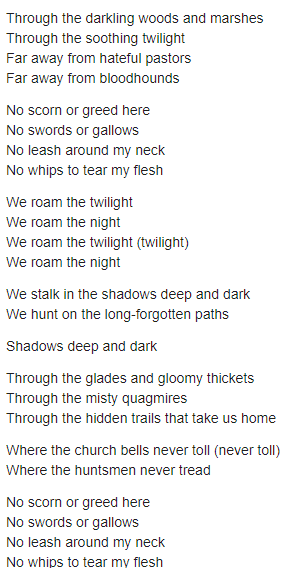

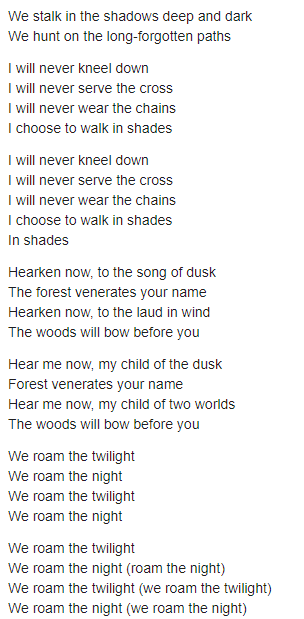

In [30]:
song_of_the_dusk = ['through', 'far', 'no', 'we', 'shadows', 'where', 'i', 'in', 'hearken', 'the']
for word in song_of_the_dusk:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> through the lo fi <end> 
<start> far out shocking and <end> 


<start> no i don t have any_money <end> 
<start> we re gonna get you <end> 
<start> shadows outta the head <end> 
<start> where the eagles cry <end> 
<start> i m not the only_one <end> 
<start> in the middle_of the night <end> 
<start> <unk> on the moonlight <end> 
<start> the world s going down <end> 


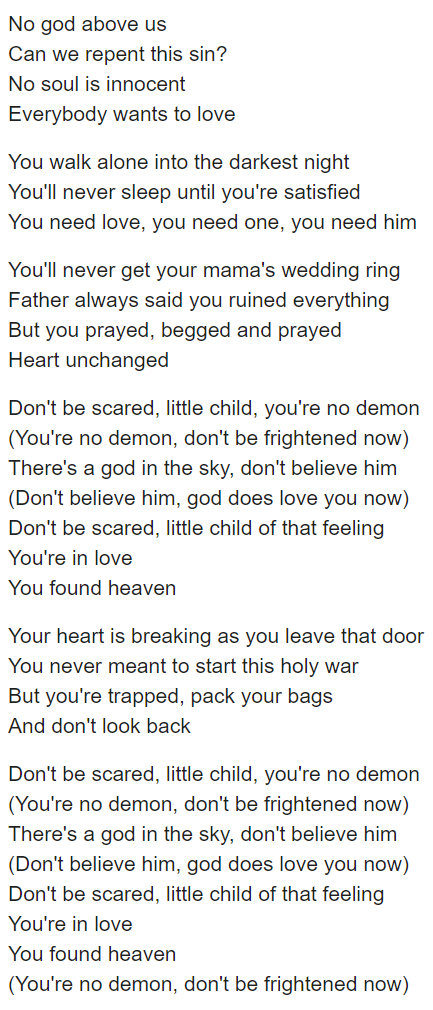

In [31]:
found_heaven = ['no', 'can', 'everybody', 'you', 'father', 'but', 'heart', 'don', 'there', 'your']
for word in found_heaven:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> no i don t have any_money <end> 
<start> can you see my name <end> 


<start> everybody _everybody everybody_livin now <end> 
<start> you re gonna be the one <end> 
<start> father to the prom <end> 
<start> but i ll be here <end> 
<start> heart to the party <end> 
<start> don t you know <end> 
<start> there s a party on a string <end> 
<start> your name is the day <end> 


: 